In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import allel


In [3]:
# import TPM data from kallisto folder for each sample
import os 

dfs = []

for folder in os.listdir('/mnt/x/analysis/kallisto_results/'):
    df = pd.read_csv('/mnt/x/analysis/kallisto_results/' + folder + '/abundance.tsv', sep='\t')
    df["sample"] = folder
    dfs.append(df)

df = pd.concat(dfs)
df

,target_id,length,eff_length,est_counts,tpm,sample
0,NM_001243976.1,1836,1574.870,10081.0000,99.796900,A1_1
1,NM_001243977.1,1578,1316.870,49009.5000,580.225000,A1_1
2,NM_001243978.1,1654,1392.870,27720.7000,310.279000,A1_1
3,NM_001243979.1,1626,1364.870,98429.5000,1124.330000,A1_1
4,NM_001243980.1,1344,1082.870,2722.0000,39.189600,A1_1
...,...,...,...,...,...,...
55434,XR_004772669.1,1386,1164.540,229.1120,4.792730,B8_3
55435,XR_004772670.1,507,307.871,79.0871,6.257870,B8_3
55436,XR_004772671.1,1037,815.543,0.0000,0.000000,B8_3
55437,XR_004772672.1,315,147.945,0.0000,0.000000,B8_3


In [4]:
# from df average TPM for each gene across triplicates; first split sample name to 3 parts - sample, timepoint, replicate. Then group by gene and sample and calculate mean TPM and std
df["smpl"] = df.apply(lambda x: x["sample"].split("_")[0], axis=1)
df["replicate"] = df.apply(lambda x: x["sample"].split("_")[1], axis=1)
df

,target_id,length,eff_length,est_counts,tpm,sample,smpl,replicate
0,NM_001243976.1,1836,1574.870,10081.0000,99.796900,A1_1,A1,1
1,NM_001243977.1,1578,1316.870,49009.5000,580.225000,A1_1,A1,1
2,NM_001243978.1,1654,1392.870,27720.7000,310.279000,A1_1,A1,1
3,NM_001243979.1,1626,1364.870,98429.5000,1124.330000,A1_1,A1,1
4,NM_001243980.1,1344,1082.870,2722.0000,39.189600,A1_1,A1,1
...,...,...,...,...,...,...,...,...
55434,XR_004772669.1,1386,1164.540,229.1120,4.792730,B8_3,B8,3
55435,XR_004772670.1,507,307.871,79.0871,6.257870,B8_3,B8,3
55436,XR_004772671.1,1037,815.543,0.0000,0.000000,B8_3,B8,3
55437,XR_004772672.1,315,147.945,0.0000,0.000000,B8_3,B8,3


In [5]:
df_grp = df.groupby(["target_id", "smpl"]).agg({"tpm": ["mean", "std"]}).reset_index()

# remove multiindex
df_grp.columns = df_grp.columns.droplevel(1)
df_grp.columns = ["target_id", "smpl", "mean_tpm", "std_tpm"]
df_grp["batch"] = df_grp.apply(lambda x: x["smpl"][0], axis=1)
df_grp["timepoint"] = df_grp.apply(lambda x: x["smpl"][1], axis=1)
df_grp

,target_id,smpl,mean_tpm,std_tpm,batch,timepoint
0,NM_001243976.1,A1,98.939700,1.232380,A,1
1,NM_001243976.1,A2,74.863967,3.343123,A,2
2,NM_001243976.1,A3,48.756300,1.336344,A,3
3,NM_001243976.1,A4,50.612000,0.859908,A,4
4,NM_001243976.1,A5,44.468900,0.183863,A,5
...,...,...,...,...,...,...
887019,XR_004772673.1,B4,0.693975,0.139805,B,4
887020,XR_004772673.1,B5,0.597054,0.044491,B,5
887021,XR_004772673.1,B6,0.721372,0.252016,B,6
887022,XR_004772673.1,B7,0.853019,0.141414,B,7


In [6]:
def geneset_to_pandas(geneset):
    """Life is a bit easier when a geneset is a pandas DataFrame."""
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        # convert bytes columns to unicode (which pandas then converts to object)
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pd.DataFrame.from_dict(dict(items))


In [7]:
geneset = allel.FeatureTable.from_gff3('/mnt/x/analysis/ref/CriGri-PICRH-1.gff', attributes=['ID', 'Parent', 'Name', 'Dbxref', 'gbkey', 'gene', 'product', 'transcript_id', 'protein_id'])
geneset = geneset_to_pandas(geneset)

In [8]:
# contains RNA in type column values
geneset_transcipts = geneset[geneset["type"].str.contains("RNA")]

geneset_transcipts

,seqid,source,type,start,end,score,strand,phase,ID,Parent,Name,Dbxref,gbkey,gene,product,transcript_id,protein_id
2,NW_023276806.1,Gnomon,mRNA,34709,35129,-1.0,+,-1,rna-XM_035450640.1,gene-LOC100752894,XM_035450640.1,"GeneID:100752894,Genbank:XM_035450640.1",mRNA,LOC100752894,"FGFR1 oncogene partner 2 homolog, transcript v...",XM_035450640.1,.
18,NW_023276806.1,Gnomon,mRNA,91104,212187,-1.0,-,-1,rna-XM_027395219.2,gene-Wls,XM_027395219.2,"GeneID:100767200,Genbank:XM_027395219.2",mRNA,Wls,"Wnt ligand secretion mediator, transcript vari...",XM_027395219.2,.
43,NW_023276806.1,Gnomon,mRNA,91104,212187,-1.0,-,-1,rna-XM_027395220.2,gene-Wls,XM_027395220.2,"GeneID:100767200,Genbank:XM_027395220.2",mRNA,Wls,"Wnt ligand secretion mediator, transcript vari...",XM_027395220.2,.
72,NW_023276806.1,Gnomon,mRNA,327075,366474,-1.0,-,-1,rna-XM_027395218.2,gene-Rpe65,XM_027395218.2,"GeneID:100767488,Genbank:XM_027395218.2",mRNA,Rpe65,retinoid isomerohydrolase RPE65,XM_027395218.2,.
103,NW_023276806.1,Gnomon,mRNA,389426,429726,-1.0,-,-1,rna-XM_027395217.2,gene-Depdc1,XM_027395217.2,"GeneID:100767779,Genbank:XM_027395217.2",mRNA,Depdc1,"DEP domain containing 1, transcript variant X4",XM_027395217.2,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265025,NW_023277442.1,Gnomon,mRNA,812,4339,-1.0,-,-1,rna-XM_027434153.1,gene-LOC100753588,XM_027434153.1,"GeneID:100753588,Genbank:XM_027434153.1",mRNA,LOC100753588,leukocyte immunoglobulin-like receptor subfami...,XM_027434153.1,.
1265041,NW_023277442.1,Gnomon,mRNA,17126,24221,-1.0,-,-1,rna-XM_027434150.2,gene-LOC100753890,XM_027434150.2,"GeneID:100753890,Genbank:XM_027434150.2",mRNA,LOC100753890,leukocyte immunoglobulin-like receptor subfami...,XM_027434150.2,.
1265073,NW_023277442.1,Gnomon,mRNA,25691,26061,-1.0,-,-1,rna-XM_035453948.1,gene-LOC118239831,XM_035453948.1,"GeneID:118239831,Genbank:XM_035453948.1",mRNA,LOC118239831,ubiquitin-60S ribosomal protein L40-like,XM_035453948.1,.
1265079,NW_023277442.1,Gnomon,mRNA,40076,46210,-1.0,-,-1,rna-XM_035453949.1,gene-LOC100765406,XM_035453949.1,"GeneID:100765406,Genbank:XM_035453949.1",mRNA,LOC100765406,leukocyte immunoglobulin-like receptor subfami...,XM_035453949.1,.


In [9]:
df_grpa = df_grp.merge(geneset_transcipts[["ID", 'transcript_id', "type", "gene", "Dbxref", "product"]], left_on="target_id", right_on="transcript_id", how="left")

In [30]:
peptidases = df_grpa[df_grpa["product"].str.contains('carboxypeptidase', na=False)].sort_values("mean_tpm", ascending=False)

# average TPM for each gene across all samples needs to be > 1
peptidases = peptidases.groupby("gene").filter(lambda x: x["mean_tpm"].mean() > 1)

peptidases

,target_id,smpl,mean_tpm,std_tpm,batch,timepoint,ID,transcript_id,type,gene,Dbxref,product
447367,XM_027426286.2,A8,296.042333,6.019736,A,8,rna-XM_027426286.2,XM_027426286.2,mRNA,Scpep1,"GeneID:100760556,Genbank:XM_027426286.2",serine carboxypeptidase 1
447366,XM_027426286.2,A7,271.597667,0.804146,A,7,rna-XM_027426286.2,XM_027426286.2,mRNA,Scpep1,"GeneID:100760556,Genbank:XM_027426286.2",serine carboxypeptidase 1
447375,XM_027426286.2,B8,191.784000,4.494898,B,8,rna-XM_027426286.2,XM_027426286.2,mRNA,Scpep1,"GeneID:100760556,Genbank:XM_027426286.2",serine carboxypeptidase 1
447365,XM_027426286.2,A6,180.294667,8.126097,A,6,rna-XM_027426286.2,XM_027426286.2,mRNA,Scpep1,"GeneID:100760556,Genbank:XM_027426286.2",serine carboxypeptidase 1
447374,XM_027426286.2,B7,174.768667,3.897846,B,7,rna-XM_027426286.2,XM_027426286.2,mRNA,Scpep1,"GeneID:100760556,Genbank:XM_027426286.2",serine carboxypeptidase 1
...,...,...,...,...,...,...,...,...,...,...,...,...
239836,XM_027407582.2,B5,0.414281,0.091084,B,5,rna-XM_027407582.2,XM_027407582.2,mRNA,LOC100768684,"GeneID:100768684,Genbank:XM_027407582.2","glutamate carboxypeptidase 2, transcript varia..."
239833,XM_027407582.2,B2,0.409709,0.156476,B,2,rna-XM_027407582.2,XM_027407582.2,mRNA,LOC100768684,"GeneID:100768684,Genbank:XM_027407582.2","glutamate carboxypeptidase 2, transcript varia..."
239831,XM_027407582.2,A8,0.347118,0.146876,A,8,rna-XM_027407582.2,XM_027407582.2,mRNA,LOC100768684,"GeneID:100768684,Genbank:XM_027407582.2","glutamate carboxypeptidase 2, transcript varia..."
239825,XM_027407582.2,A2,0.294137,0.061191,A,2,rna-XM_027407582.2,XM_027407582.2,mRNA,LOC100768684,"GeneID:100768684,Genbank:XM_027407582.2","glutamate carboxypeptidase 2, transcript varia..."


In [31]:
peptidases.pivot(index="product", columns="smpl", values="mean_tpm")

smpl,A1,A2,A3,A4,A5,A6,A7,A8,B1,B2,B3,B4,B5,B6,B7,B8
product,,,,,,,,,,,,,,,,
carboxypeptidase A6,0.633521,0.712579,0.811149,1.055026,1.323460,1.401890,0.850667,0.854127,0.467194,0.801187,1.100878,0.849106,1.038048,1.480077,2.472650,2.427733
carboxypeptidase D,38.098767,51.961467,62.808333,64.355867,62.352133,63.016133,70.660533,72.580167,35.357600,47.999700,51.909733,42.360433,32.326367,30.023200,43.894967,47.026467
carboxypeptidase N subunit 1,8.001243,10.134137,13.820633,13.335000,12.538667,11.398000,9.757057,9.358823,7.574473,9.278087,10.708567,15.633900,15.824567,17.077667,18.438067,16.389367
"glutamate carboxypeptidase 2, transcript variant X4",8.311777,8.190153,9.058970,9.544880,10.926700,11.070833,10.238553,11.471200,6.578687,7.902490,8.867300,7.363437,7.376977,7.413807,12.121167,14.400733
"glutamate carboxypeptidase 2, transcript variant X5",0.524289,0.294137,0.886314,0.898149,0.584553,0.682889,0.646973,0.347118,0.506479,0.409709,1.033563,0.679226,0.414281,0.243926,1.292607,0.802781
"glutamate carboxypeptidase 2, transcript variant X6",0.460784,0.764192,2.137440,2.072213,1.429560,1.453207,2.951173,2.178730,0.532822,0.786178,1.322420,1.947270,1.543490,2.053627,3.045913,2.685123
lysosomal Pro-X carboxypeptidase,42.594467,43.156200,31.926400,27.050067,31.404667,32.148800,38.707267,40.384900,36.876967,49.605067,44.219200,34.958267,32.861267,34.948700,57.492867,64.099800
serine carboxypeptidase 1,93.279733,148.389333,155.702000,138.458333,145.513333,180.294667,271.597667,296.042333,81.374967,121.390333,138.184000,128.913333,123.540000,127.878667,174.768667,191.784000


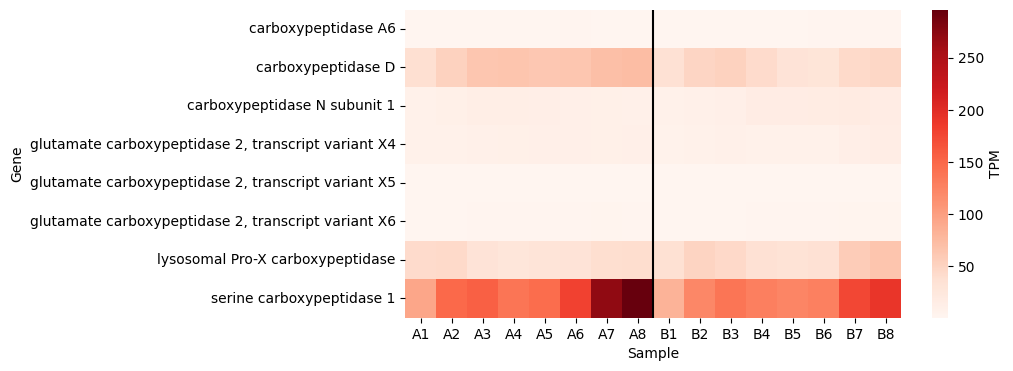

<Figure size 640x480 with 0 Axes>

In [32]:
# make a heatmap of peptidases for each timepoint on x axis and gene/product on y axis, put A1 and B1 next to each other, then A2 and B2, etc
peptidases["smpl"] = peptidases["smpl"].astype("category")
peptidases["smpl"].cat.reorder_categories(["A1", "B1", "A2", "B2", "A3", "B3", "A4", "B4", "A5", "B5", "A6", "B6", "A7", "B7", "A8", "B8"])
peptidases = peptidases.sort_values("smpl")

# make a heatmap of peptidases for each smpl on x axis and gene/product on y axis
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(peptidases.pivot(index="product", columns="smpl", values="mean_tpm"), cmap="Reds", ax=ax)
# make a vertical line after A8
ax.axvline(8, color="black")
# annotate timepoints
ax.set_xlabel("Sample")
ax.set_ylabel("Gene")
# set legend label to "TPM"
cbar = ax.collections[0].colorbar
cbar.set_label("TPM")
plt.show()
plt.savefig("/mnt/x/analysis/heatmap_peptidases.pdf", bbox_inches="tight", dpi=300)

In [34]:
# peptidases = df_grpa[df_grpa["product"].str.contains('carboxylesterase', na=False) & ~(df_grpa["product"].str.contains('variant', na=False))].sort_values("mean_tpm", ascending=False)
peptidases = df_grpa[df_grpa["product"].str.contains('carboxylesterase', na=False)].sort_values("mean_tpm", ascending=False)

# average TPM for each gene across all samples needs to be > 1
peptidases = peptidases.groupby("gene").filter(lambda x: x["mean_tpm"].mean() > 1)

peptidases

# tilde is negation


,target_id,smpl,mean_tpm,std_tpm,batch,timepoint,ID,transcript_id,type,gene,Dbxref,product
217845,XM_027405611.2,A6,23.599133,0.988633,A,6,rna-XM_027405611.2,XM_027405611.2,mRNA,LOC100769145,"GeneID:100769145,Genbank:XM_027405611.2",carboxylesterase 1F
217847,XM_027405611.2,A8,22.412933,0.821806,A,8,rna-XM_027405611.2,XM_027405611.2,mRNA,LOC100769145,"GeneID:100769145,Genbank:XM_027405611.2",carboxylesterase 1F
217846,XM_027405611.2,A7,21.890100,0.802369,A,7,rna-XM_027405611.2,XM_027405611.2,mRNA,LOC100769145,"GeneID:100769145,Genbank:XM_027405611.2",carboxylesterase 1F
217855,XM_027405611.2,B8,19.311000,0.678923,B,8,rna-XM_027405611.2,XM_027405611.2,mRNA,LOC100769145,"GeneID:100769145,Genbank:XM_027405611.2",carboxylesterase 1F
217844,XM_027405611.2,A5,19.224367,0.412617,A,5,rna-XM_027405611.2,XM_027405611.2,mRNA,LOC100769145,"GeneID:100769145,Genbank:XM_027405611.2",carboxylesterase 1F
...,...,...,...,...,...,...,...,...,...,...,...,...
217830,XM_027405610.2,A7,0.214931,0.300286,A,7,rna-XM_027405610.2,XM_027405610.2,mRNA,LOC100769432,"GeneID:100769432,Genbank:XM_027405610.2","liver carboxylesterase 1, transcript variant X2"
437093,XM_027425376.2,A6,0.189870,0.212268,A,6,rna-XM_027425376.2,XM_027425376.2,mRNA,Notum,"GeneID:100768485,Genbank:XM_027425376.2","notum, palmitoleoyl-protein carboxylesterase, ..."
437096,XM_027425376.2,B1,0.167540,0.180828,B,1,rna-XM_027425376.2,XM_027425376.2,mRNA,Notum,"GeneID:100768485,Genbank:XM_027425376.2","notum, palmitoleoyl-protein carboxylesterase, ..."
217829,XM_027405610.2,A6,0.133382,0.231024,A,6,rna-XM_027405610.2,XM_027405610.2,mRNA,LOC100769432,"GeneID:100769432,Genbank:XM_027405610.2","liver carboxylesterase 1, transcript variant X2"


In [37]:
peptidases.pivot(index="ID", columns="smpl", values="mean_tpm")

smpl,A1,A2,A3,A4,A5,A6,A7,A8,B1,B2,B3,B4,B5,B6,B7,B8
ID,,,,,,,,,,,,,,,,
rna-XM_027405609.2,7.387300,5.344137,4.858027,3.918143,2.532010,4.037133,4.778293,4.905463,8.349440,7.311327,5.989367,3.147953,2.823673,2.923570,4.749903,4.889370
rna-XM_027405610.2,1.149983,0.449384,0.477092,0.334758,1.103791,0.133382,0.214931,0.586635,1.114496,0.741635,0.624446,0.302815,0.067070,0.470099,0.415557,0.970432
rna-XM_027405611.2,0.563707,2.909227,6.876467,12.958067,19.224367,23.599133,21.890100,22.412933,1.568227,2.614627,3.504000,4.981547,6.681123,8.335163,17.204767,19.311000
rna-XM_027425373.2,0.564321,1.597460,1.902030,2.100600,1.728323,1.836460,1.458320,1.045669,0.700847,1.931327,3.121407,4.397150,3.727287,3.444800,1.896590,2.052830
rna-XM_027425376.2,0.286872,0.540496,0.719650,0.499362,0.572624,0.189870,0.331837,0.320865,0.167540,1.173369,1.265092,1.139028,1.597822,1.416863,1.653738,1.556447
rna-XM_035441683.1,0.341524,1.899500,3.668493,3.066073,2.677927,3.076790,2.949283,3.072467,1.171040,1.631970,1.878157,1.009502,0.638361,0.711929,1.518833,1.955387


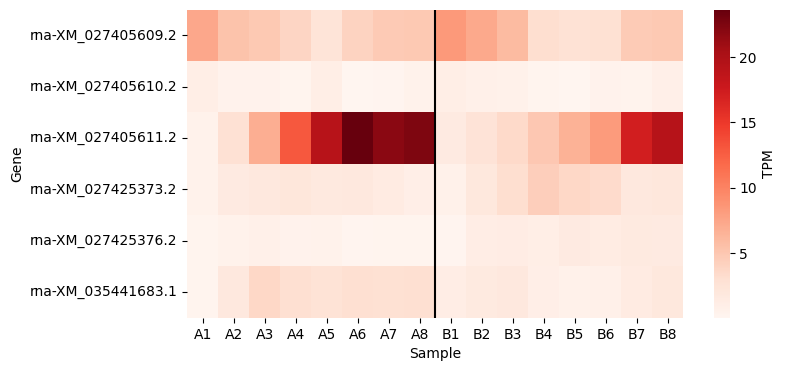

In [39]:
# make a heatmap of peptidases for each timepoint on x axis and gene/product on y axis, put A1 and B1 next to each other, then A2 and B2, etc
peptidases["smpl"] = peptidases["smpl"].astype("category")
peptidases["smpl"].cat.reorder_categories(["A1", "B1", "A2", "B2", "A3", "B3", "A4", "B4", "A5", "B5", "A6", "B6", "A7", "B7", "A8", "B8"])
peptidases = peptidases.sort_values("smpl")

# make a heatmap of peptidases for each smpl on x axis and gene/product on y axis
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(peptidases.pivot(index="ID", columns="smpl", values="mean_tpm"), cmap="Reds", ax=ax)
# make a vertical line after A8
ax.axvline(8, color="black")
# annotate timepoints
ax.set_xlabel("Sample")
ax.set_ylabel("Gene")
# set legend label to "TPM"
cbar = ax.collections[0].colorbar
cbar.set_label("TPM")
plt.show()
# plt.savefig("/mnt/x/analysis/heatmap_caspase.pdf", bbox_inches="tight", dpi=300)